# Extract features

This notebook demonstrates how to compute features about the cellular micro-environment and add them to the anndata object. 

The inputs of this analysis are:
1. full checkpoint file (with both the model and datamodule). 
2. anndata object describing the tissue for which you want to extract the features

The output is the same anndata object with some extra annotations (stored in anndata.obsm)

We compute two types of features. 

1. The neighborhood composition vector (ncv) of each cell describes the proportion of cell_types in a local negihborhood. It can be computed by specifying the number of neighbours or the radius of the neighboorhood.
2. The semantic features learned by a self supervised model.

To compute the semantic features we follow this procedure:
- the anndata is converted into a sparse image
- the sparse image is cropped in overlapping patches which are fed into the trained model to extract patch-level features
- the patch-level features are transferred to the underlying cells
- the anndata object is exported with the additional features stored in anndata.obsm

This notebook assumes that main_1_train_ssl.py has been run already.

This notebook is for demonstration only. 

To reproduce the results in the paper run the scripts in the "run" folder. 

See documentation for more details.

In [1]:
# TO REMOVE when notebook is stable

%load_ext autoreload
%autoreload 2

### Common Imports

In [2]:
import numpy
import torch
import seaborn
import tarfile
import os
import matplotlib
import matplotlib.pyplot as plt
from anndata import read_h5ad

# tissue_purifier import
import tissue_purifier as tp

### Download the example dataset

In [7]:
## replace with your own path
data_destination_folder = "../../TissueMosaic_Figures/TissueMosaic_data/testis_anndata_corrected_doubletmode_annotated/"

# Make a list of all the h5ad files in the data_destination_folder
fname_list = []
for f in os.listdir(data_destination_folder):
    if f.endswith('.h5ad'):
        fname_list.append(f)
print(fname_list)

['wt3_dm.h5ad', 'wt1_dm.h5ad', 'diabetes2_dm.h5ad', 'wt2_dm.h5ad', 'diabetes1_dm.h5ad', 'diabetes3_dm.h5ad']


### Download the checkpoint file 
Altenatively you can use the checkpoint file generated by running notebook1.

In [8]:
## replace with your own path
ckpt_destination_path = "../../model_checkpoints/testis/testis_dino.pt"

### Read in all anndata files

In [9]:
anndata_list = []
for fname in fname_list:
    anndata = read_h5ad(os.path.join(data_destination_folder, fname))
    print("Loaded {}".format(fname))
    anndata_list.append(anndata)

Loaded wt3_dm.h5ad
Loaded wt1_dm.h5ad
Loaded diabetes2_dm.h5ad
Loaded wt2_dm.h5ad
Loaded diabetes1_dm.h5ad
Loaded diabetes3_dm.h5ad


### Recreate the model and datamodule used for training. 

Here we use Dino but the same apporach works for Barlow, Simclr, and Vae

In [10]:
from tissue_purifier.data import AnndataFolderDM
from tissue_purifier.models.ssl_models import *
# now you have access to Barlow, SImclr, Dino, Vae


model = tp.models.ssl_models.Dino.load_from_checkpoint(checkpoint_path=ckpt_destination_path, strict=False)
dm = tp.data.AnndataFolderDM(**model._hparams) 

[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and func

### Convert the anndata to sparse images

Note that we use the 'anndata_to_sparseimage' method defined in the datamodule. \
We therefore know that we are making the sparse_images using the exact same recipe which was used during training. 

In [11]:
sp_imgs = [dm.anndata_to_sparseimage(anndata) for anndata in anndata_list]

number of elements ---> 29178
mean and median spacing 15.90507495709278, 15.497339152935078
The dense shape of the image is -> torch.Size([9, 1178, 1175])
number of elements ---> 27840
mean and median spacing 16.009033744023068, 15.768961335552781
The dense shape of the image is -> torch.Size([9, 1160, 1143])
number of elements ---> 29607
mean and median spacing 15.810478612949094, 15.727658385209352
The dense shape of the image is -> torch.Size([9, 1180, 855])
number of elements ---> 30132
mean and median spacing 16.353857684013548, 15.931447916615909
The dense shape of the image is -> torch.Size([9, 1180, 1180])
number of elements ---> 34868
mean and median spacing 15.821949004591055, 15.638433550603624
The dense shape of the image is -> torch.Size([9, 1180, 1181])
number of elements ---> 34868
mean and median spacing 15.821949004591055, 15.638433550603624
The dense shape of the image is -> torch.Size([9, 1180, 1181])


### Visualize one sparse_image as a sanity check

torch.Size([3, 1178, 1175])


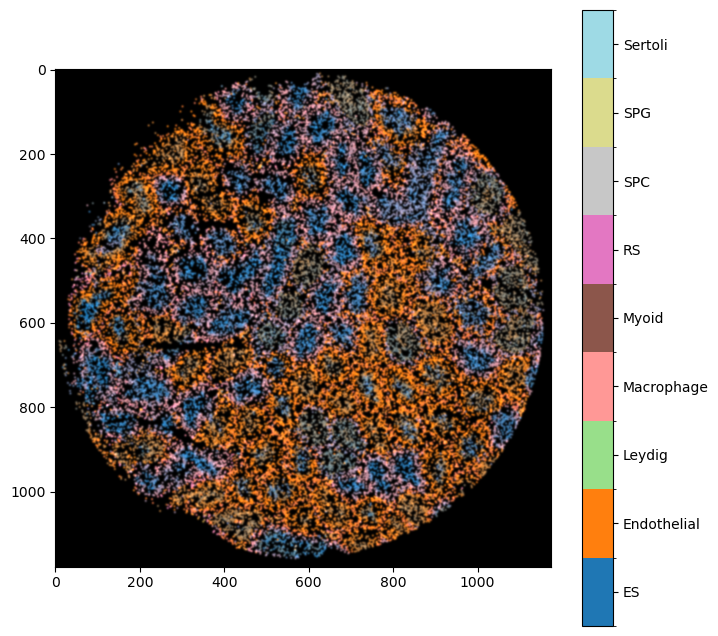

In [12]:
x, fig = sp_imgs[0].to_rgb(contrast=1.5)
print(x.shape)
fig

### Inspect the content of one sparse_image

Note that initially only the spot dictionary is non-empty

In [13]:
sp_imgs[0].inspect()


-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (29178,)
 y_key <class 'numpy.ndarray'> (29178,)
 ES <class 'pandas.core.series.Series'>
 RS <class 'pandas.core.series.Series'>
 Myoid <class 'pandas.core.series.Series'>
 SPC <class 'pandas.core.series.Series'>
 SPG <class 'pandas.core.series.Series'>
 Sertoli <class 'pandas.core.series.Series'>
 Leydig <class 'pandas.core.series.Series'>
 Endothelial <class 'pandas.core.series.Series'>
 Macrophage <class 'pandas.core.series.Series'>
 UMI <class 'pandas.core.series.Series'>
 cell_type <class 'pandas.core.series.Series'>

-- patch_properties_dict --

-- image_properties_dict --


### Compute the neighborhood composition vectors (ncv) at a given resolution 

Here we compute the features based on the k nearest neighbours. \
The same could be done by providing a radius so that only the neighbours within that radius are used.

In [14]:
for k in (25, 50, 100, 200, 500, 1000):
    sp_imgs[0].compute_ncv(feature_name="ncv_k{}".format(k), k=k)
sp_imgs[0].inspect()


-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (29178,)
 y_key <class 'numpy.ndarray'> (29178,)
 ES <class 'pandas.core.series.Series'>
 RS <class 'pandas.core.series.Series'>
 Myoid <class 'pandas.core.series.Series'>
 SPC <class 'pandas.core.series.Series'>
 SPG <class 'pandas.core.series.Series'>
 Sertoli <class 'pandas.core.series.Series'>
 Leydig <class 'pandas.core.series.Series'>
 Endothelial <class 'pandas.core.series.Series'>
 Macrophage <class 'pandas.core.series.Series'>
 UMI <class 'pandas.core.series.Series'>
 cell_type <class 'pandas.core.series.Series'>
 ncv_k25 <class 'numpy.ndarray'> (29178, 9)
 ncv_k50 <class 'numpy.ndarray'> (29178, 9)
 ncv_k100 <class 'numpy.ndarray'> (29178, 9)
 ncv_k200 <class 'numpy.ndarray'> (29178, 9)
 ncv_k500 <class 'numpy.ndarray'> (29178, 9)
 ncv_k1000 <class 'numpy.ndarray'> (29178, 9)

-- patch_properties_dict --

-- image_properties_dict --


### Compute the Dino self-supervised features by "tiling" 
( i.e. split the image in overlapping patches and feeding each patch to the model to extract patch-level features)

In [15]:
# Restars the analysis from scratch if necessary
# sp_imgs[0].clear(patch_dict=True, image_dict=True)
# sp_imgs[0].trim_spot_dictionary(keys="dino")
# sp_imgs[0].inspect()

In [18]:
n_patches_max = 1000 # cover the tissue with this many overlapping patches

# put sparse images and model on GPU if available
if torch.cuda.is_available():
    sp_imgs = [tmp.cuda() for tmp in sp_imgs]
    model = model.cuda()

sp_imgs[0].compute_patch_features(
    feature_name="dino", 
    datamodule=dm, 
    model=model, 
    batch_size=64,
    strategy='random',
    remove_overlap=False,
    n_patches_max=n_patches_max,
    overwrite=True)

# Note that the patch properties dictionary is not empty
sp_imgs[0].inspect()

The key dino is already present in patch_properties_dict and it will be overwritten



-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (29178,)
 y_key <class 'numpy.ndarray'> (29178,)
 ES <class 'pandas.core.series.Series'>
 RS <class 'pandas.core.series.Series'>
 Myoid <class 'pandas.core.series.Series'>
 SPC <class 'pandas.core.series.Series'>
 SPG <class 'pandas.core.series.Series'>
 Sertoli <class 'pandas.core.series.Series'>
 Leydig <class 'pandas.core.series.Series'>
 Endothelial <class 'pandas.core.series.Series'>
 Macrophage <class 'pandas.core.series.Series'>
 UMI <class 'pandas.core.series.Series'>
 cell_type <class 'pandas.core.series.Series'>
 ncv_k25 <class 'numpy.ndarray'> (29178, 9)
 ncv_k50 <class 'numpy.ndarray'> (29178, 9)
 ncv_k100 <class 'numpy.ndarray'> (29178, 9)
 ncv_k200 <class 'numpy.ndarray'> (29178, 9)
 ncv_k500 <class 'numpy.ndarray'> (29178, 9)
 ncv_k1000 <class 'numpy.ndarray'> (29178, 9)

-- patch_properties_dict --
 dino <class 'numpy.ndarray'> (1000, 512)
 dino_patch_xywh <class 'numpy.ndarray'> (1000, 4)
 patch_ncv <class 'num

### Transfer annotations

Now we transfer the annotation from the patch to the spot level. \
Internally the annotation are first transferred patch -> image  and then image -> spot. \
This provides an approximation to computing the spot features, for demonstration purposes.

In [19]:
sp_imgs[0].transfer_patch_to_spot(keys_to_transfer=["dino"], overwrite=True)

# Note that now the the patch properties dictionary is not empty
sp_imgs[0].inspect()


-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (29178,)
 y_key <class 'numpy.ndarray'> (29178,)
 ES <class 'pandas.core.series.Series'>
 RS <class 'pandas.core.series.Series'>
 Myoid <class 'pandas.core.series.Series'>
 SPC <class 'pandas.core.series.Series'>
 SPG <class 'pandas.core.series.Series'>
 Sertoli <class 'pandas.core.series.Series'>
 Leydig <class 'pandas.core.series.Series'>
 Endothelial <class 'pandas.core.series.Series'>
 Macrophage <class 'pandas.core.series.Series'>
 UMI <class 'pandas.core.series.Series'>
 cell_type <class 'pandas.core.series.Series'>
 ncv_k25 <class 'numpy.ndarray'> (29178, 9)
 ncv_k50 <class 'numpy.ndarray'> (29178, 9)
 ncv_k100 <class 'numpy.ndarray'> (29178, 9)
 ncv_k200 <class 'numpy.ndarray'> (29178, 9)
 ncv_k500 <class 'numpy.ndarray'> (29178, 9)
 ncv_k1000 <class 'numpy.ndarray'> (29178, 9)
 dino <class 'numpy.ndarray'> (29178, 512)

-- patch_properties_dict --
 dino <class 'numpy.ndarray'> (1000, 512)
 dino_patch_xywh <class 'numpy

### Visualization as a sanity check

We could visualize one of the channels of the image-level properties. For example:

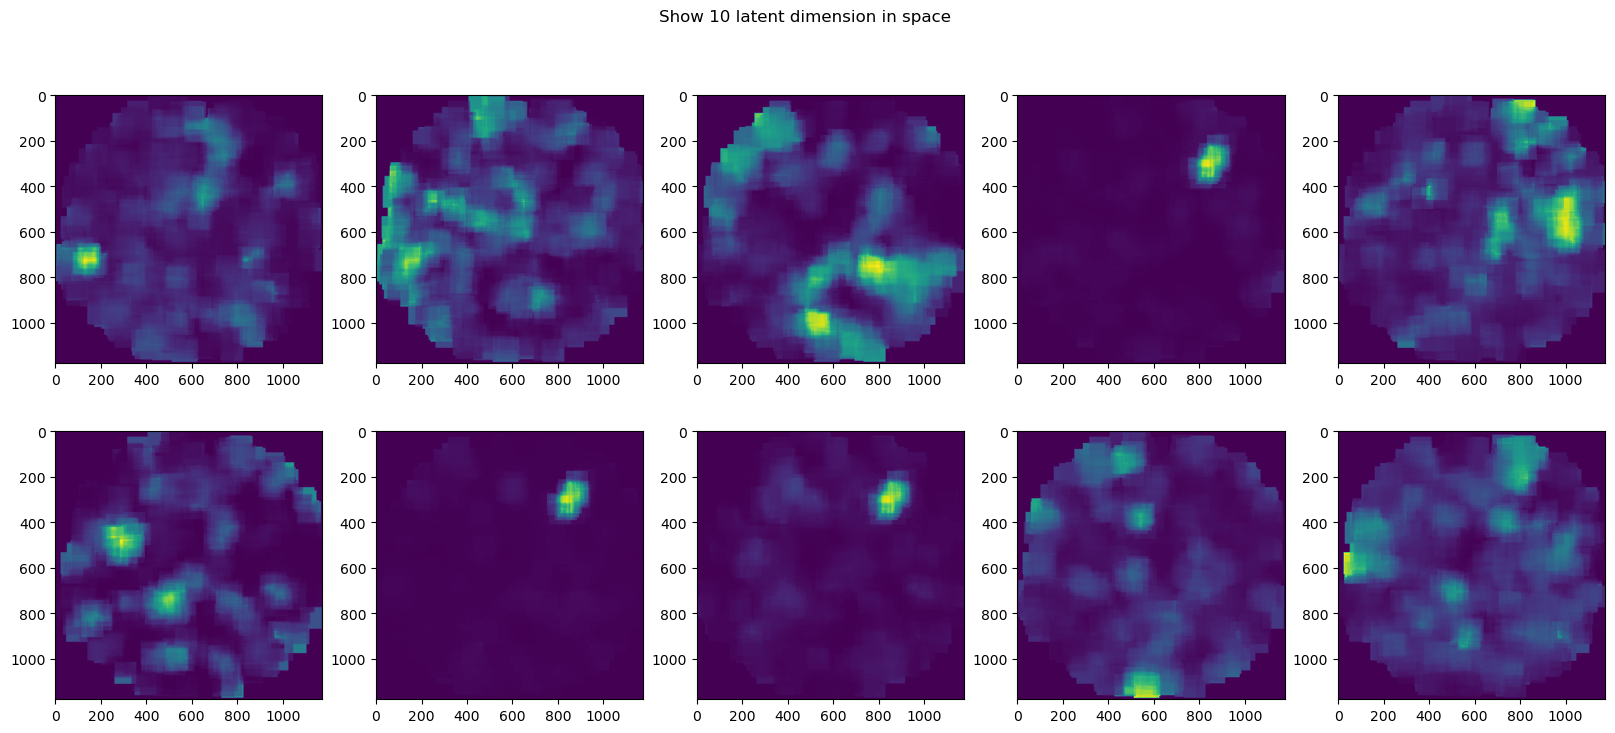

In [21]:
from tissue_purifier.plots import show_raw_one_channel
show_raw_one_channel(sp_imgs[0].read_from_image_dictionary(key="dino")[:10], 
                    n_col=5,  
                    sup_title="Show 10 latent dimension in space",
                    cmap='viridis')

However this is not very imformative. \
A better idea is to:
- first compute few PCAs of the patch-features
- convert them into a percentile, i.e in the range (0, 1)
- transfer those to the image-level for visualization

In [22]:
from tissue_purifier.utils.validation_util import SmartPca, get_percentile

compute the first few pca of the Dino features

torch.Size([1000, 512]) (1000, 10)


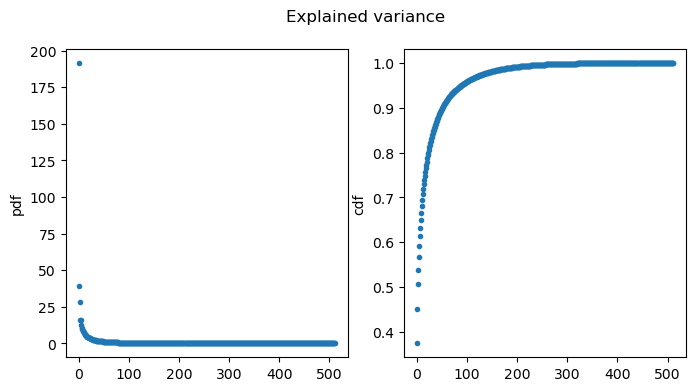

In [25]:
from tissue_purifier.plots import plot_cdf_pdf

pca = SmartPca(preprocess_strategy='z_score')

dino_values, dino_xywh = sp_imgs[0].read_from_patch_dictionary(key="dino")
dino_pca = pca.fit_transform(dino_values, n_components=10)
print(dino_values.shape, dino_pca.shape)

plot_cdf_pdf(pdf_y=pca.explained_variance_.cpu().numpy(), sup_title="Explained variance")

compute the percentile

In [26]:
dino_pca_percentile = get_percentile(dino_pca, dim=0)

# Note that now every component has been scaled in (0.0, 1.0) 
print(numpy.min(dino_pca_percentile, axis=0))
print(numpy.max(dino_pca_percentile, axis=0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [27]:
# write to patch_dictionary
sp_imgs[0].write_to_patch_dictionary(key="dino_percentile", values=dino_pca_percentile, patches_xywh=dino_xywh)

In [28]:
# transfer to image
sp_imgs[0].transfer_patch_to_spot(keys_to_transfer=["dino_percentile"], overwrite=True)

# Note that now the the patch properties dictionary is not empty
sp_imgs[0].inspect()


-- spot_properties_dict --
 x_key <class 'numpy.ndarray'> (29178,)
 y_key <class 'numpy.ndarray'> (29178,)
 ES <class 'pandas.core.series.Series'>
 RS <class 'pandas.core.series.Series'>
 Myoid <class 'pandas.core.series.Series'>
 SPC <class 'pandas.core.series.Series'>
 SPG <class 'pandas.core.series.Series'>
 Sertoli <class 'pandas.core.series.Series'>
 Leydig <class 'pandas.core.series.Series'>
 Endothelial <class 'pandas.core.series.Series'>
 Macrophage <class 'pandas.core.series.Series'>
 UMI <class 'pandas.core.series.Series'>
 cell_type <class 'pandas.core.series.Series'>
 ncv_k25 <class 'numpy.ndarray'> (29178, 9)
 ncv_k50 <class 'numpy.ndarray'> (29178, 9)
 ncv_k100 <class 'numpy.ndarray'> (29178, 9)
 ncv_k200 <class 'numpy.ndarray'> (29178, 9)
 ncv_k500 <class 'numpy.ndarray'> (29178, 9)
 ncv_k1000 <class 'numpy.ndarray'> (29178, 9)
 dino <class 'numpy.ndarray'> (29178, 512)
 dino_percentile <class 'numpy.ndarray'> (29178, 10)

-- patch_properties_dict --
 dino <class 'numpy

Now we can visualize the PCA in space

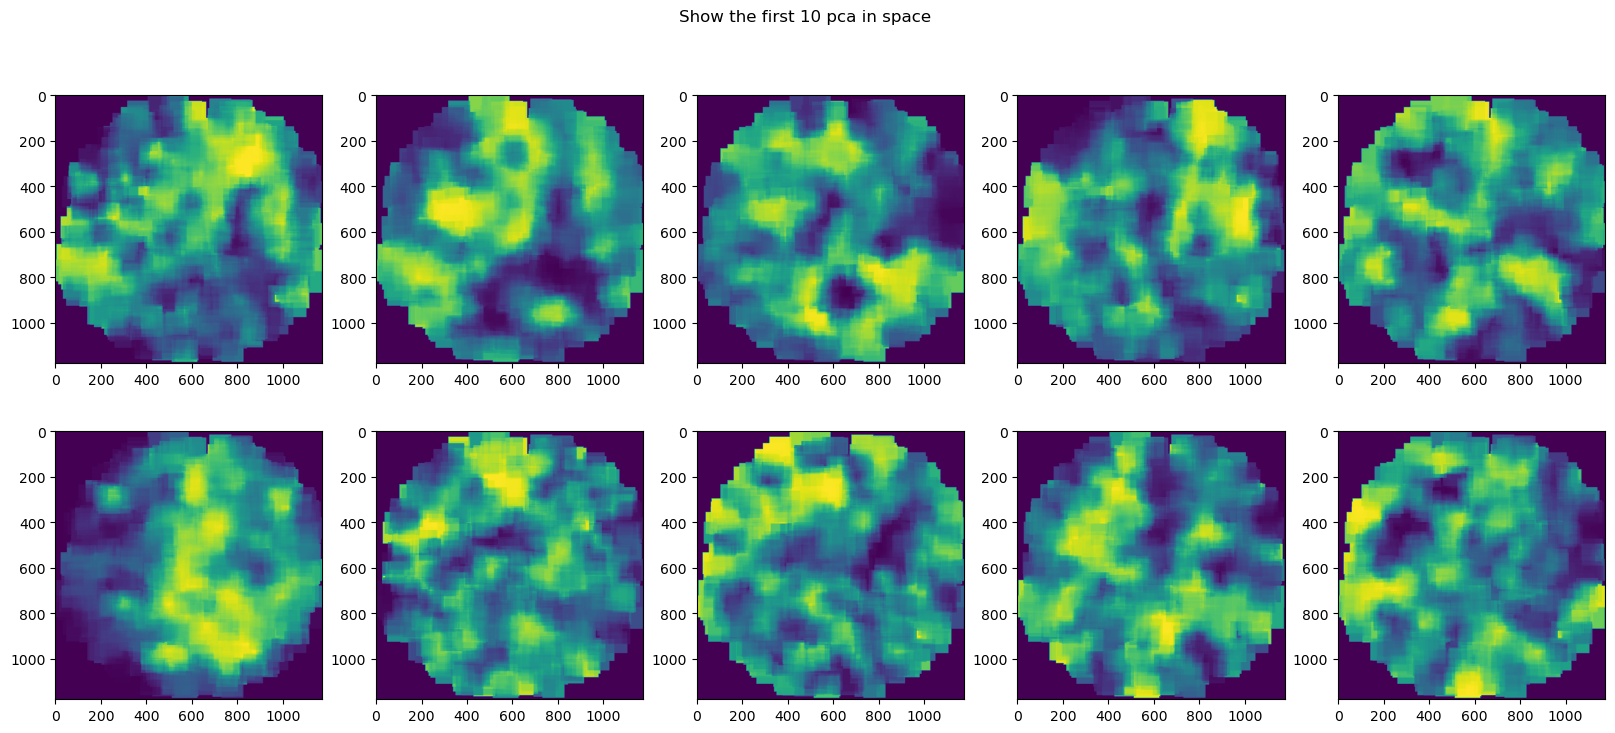

In [29]:
show_raw_one_channel(sp_imgs[0].read_from_image_dictionary(key="dino_percentile")[:10], 
                    n_col=5,  
                    sup_title="Show the first 10 pca in space",
                    cmap='viridis')

### Export the anndata and write it to file

In [30]:
adata = sp_imgs[0].to_anndata()
adata.write(filename="anndata_with_annotations.h5ad")
adata              

AnnData object with n_obs × n_vars = 29178 × 24450
    obs: 'x', 'y', 'UMI', 'cell_type'
    uns: 'status'
    obsm: 'cell_type_proportions', 'ncv_k25', 'ncv_k50', 'ncv_k100', 'ncv_k200', 'ncv_k500', 'ncv_k1000', 'dino', 'dino_percentile'

# compare UMAPs

Now we compare 3 umaps:
1. the UMAP obtained with the patch-level embeddings
2. the "standard" UMAP with the gene expression
3. the UMAP with the micro-environment annotations at the single-cell resolution

### This visualization can be especially informative when multiple samples are analyzed together (see paper figures)

### Umap of patches

In [43]:
from tissue_purifier.utils import SmartPca, SmartUmap
from tissue_purifier.utils import inspect_dict

result_dict = dict()

dino_features, patch_xywh = sp_imgs[0].read_from_patch_dictionary(key="dino")

smart_pca = SmartPca(preprocess_strategy='raw')
smart_umap = SmartUmap(n_neighbors=25, preprocess_strategy='raw', n_components=2, min_dist=0.5, metric='euclidean')

dino_pca = smart_pca.fit_transform(dino_features, n_components=0.95)
dino_umap = smart_umap.fit_transform(dino_pca)


result_dict["umap_dino"] = dino_umap
result_dict["pca_dino"] = dino_pca
inspect_dict(result_dict)

/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


 umap_dino <class 'numpy.ndarray'> (1000, 2)
 pca_dino <class 'numpy.ndarray'> (1000, 512)


Compute the cell proportion in each patch

In [44]:
from tissue_purifier.data.dataset import CropperSparseTensor
from tissue_purifier.models.patch_analyzer import SpatialAutocorrelation, Composition

list_sp_tensor, _, _ = CropperSparseTensor.reapply_crops(sp_imgs[0].data, patch_xywh) 
list_composition = Composition(return_fraction=True)(list_sp_tensor)
result_dict["composition"] = torch.stack(list_composition, dim=0).cpu().numpy()

cell_types = ["ES", "RS", "Myoid", "SPC", "SPG", "Sertoli", "Leydig", "Endothelial", "Macrophage"]
for ch, key in enumerate(cell_types):
    result_dict[key+"_proportion"] = result_dict["composition"][:,ch]
    
inspect_dict(result_dict)

 umap_dino <class 'numpy.ndarray'> (1000, 2)
 pca_dino <class 'numpy.ndarray'> (1000, 512)
 composition <class 'numpy.ndarray'> (1000, 9)
 ES_proportion <class 'numpy.ndarray'> (1000,)
 RS_proportion <class 'numpy.ndarray'> (1000,)
 Myoid_proportion <class 'numpy.ndarray'> (1000,)
 SPC_proportion <class 'numpy.ndarray'> (1000,)
 SPG_proportion <class 'numpy.ndarray'> (1000,)
 Sertoli_proportion <class 'numpy.ndarray'> (1000,)
 Leydig_proportion <class 'numpy.ndarray'> (1000,)
 Endothelial_proportion <class 'numpy.ndarray'> (1000,)
 Macrophage_proportion <class 'numpy.ndarray'> (1000,)


Compute the Moran's I score in each patch

In [45]:
list_moran = SpatialAutocorrelation(modality='moran', n_neighbours=6, neigh_correct=True)(list_sp_tensor)
result_dict["moran"] = torch.stack(list_moran, dim=0).cpu()
result_dict["max_moran"] = torch.max(result_dict["moran"], dim=-1)[0]
inspect_dict(result_dict)

 umap_dino <class 'numpy.ndarray'> (1000, 2)
 pca_dino <class 'numpy.ndarray'> (1000, 512)
 composition <class 'numpy.ndarray'> (1000, 9)
 ES_proportion <class 'numpy.ndarray'> (1000,)
 RS_proportion <class 'numpy.ndarray'> (1000,)
 Myoid_proportion <class 'numpy.ndarray'> (1000,)
 SPC_proportion <class 'numpy.ndarray'> (1000,)
 SPG_proportion <class 'numpy.ndarray'> (1000,)
 Sertoli_proportion <class 'numpy.ndarray'> (1000,)
 Leydig_proportion <class 'numpy.ndarray'> (1000,)
 Endothelial_proportion <class 'numpy.ndarray'> (1000,)
 Macrophage_proportion <class 'numpy.ndarray'> (1000,)
 moran <class 'torch.Tensor'> torch.Size([1000, 9]) cpu
 max_moran <class 'torch.Tensor'> torch.Size([1000]) cpu


/home/skambha6/miniforge3/envs/tissue_purifier/lib/python3.11/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


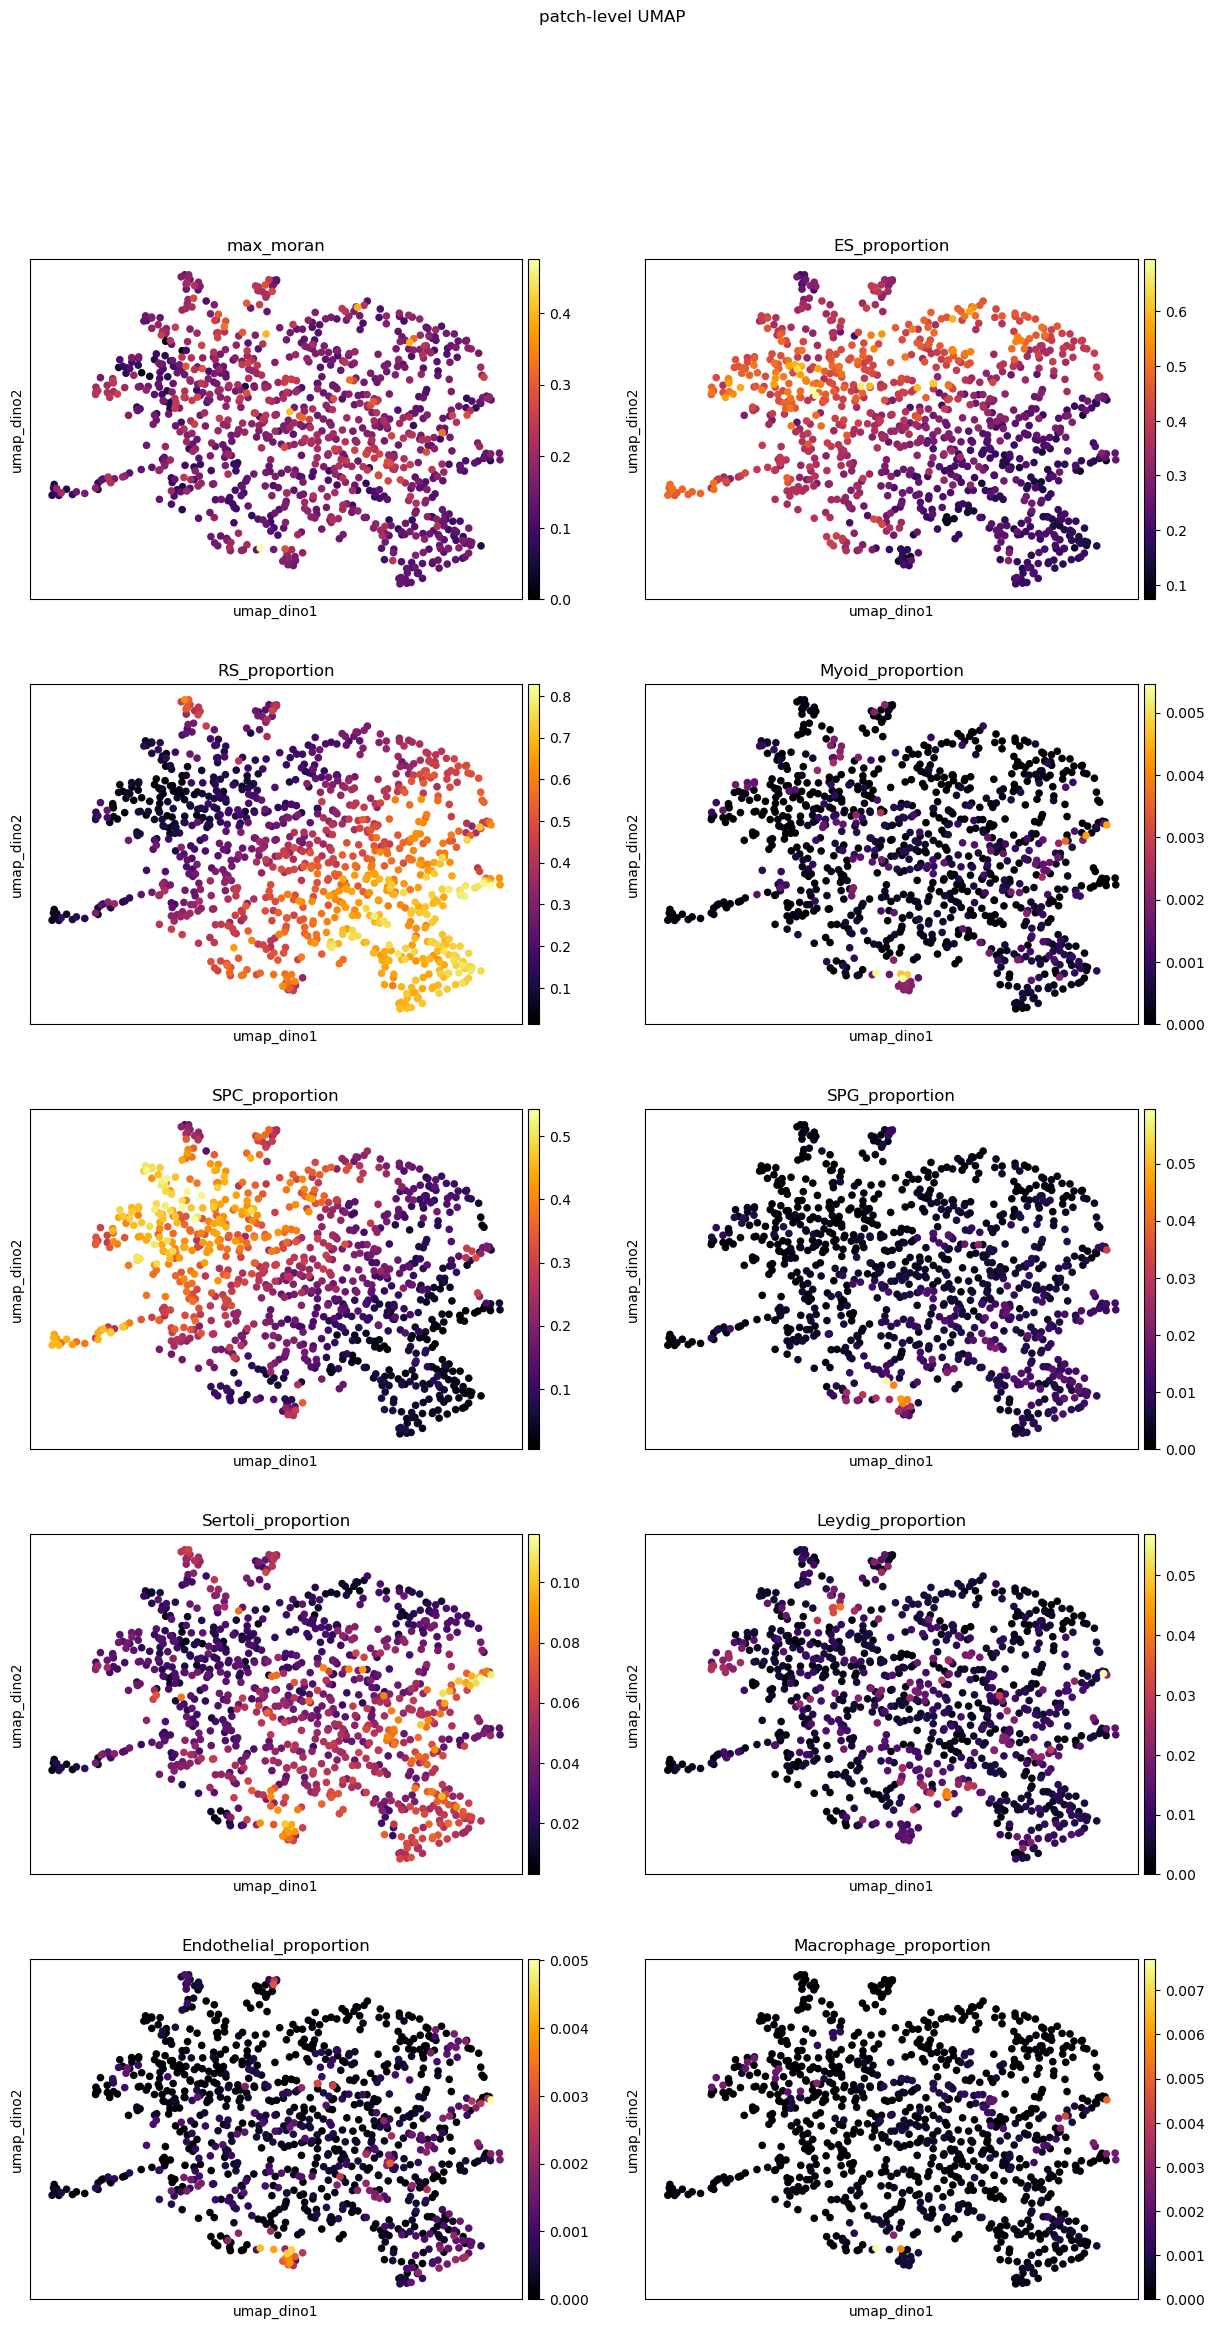

In [46]:
from tissue_purifier.plots import plot_embeddings

annotation_keys = ["max_moran"]
for k in result_dict.keys():
    if k.endswith("proportion"):
        annotation_keys.append(k)
    
umap_patch_fig = plot_embeddings(
    input_dictionary=result_dict,
    embedding_key="umap_dino",
    annotation_keys=annotation_keys,
    n_col=2,
    sup_title="patch-level UMAP")

umap_patch_fig